# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!nvidia-smi

Tue Dec 13 02:47:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [4]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/drive/'
# data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","nlp","'text gen demos'")

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/drive/


In [5]:
# copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [6]:
script = pd.read_csv('/content/drive/MyDrive/michael_project/the-office-lines - scripts.csv')
script = script[script['speaker']=='Michael']
script

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
5,6,1,1,2,"[on the phone] Yes, I'd like to speak to your ...",Michael,False
6,7,1,1,3,"I've, uh, I've been at Dunder Mifflin for 12 y...",Michael,False
...,...,...,...,...,...,...,...
44693,44694,7,21,49,Later guys. [leaves the office],Michael,False
44694,44695,7,21,50,Got almost everybody. So... Holly's my family ...,Michael,False
44695,44696,7,21,51,"[putting his shoes back on, talking to the cam...",Michael,False
59750,59751,9,23,68,That���s what she said.,Michael,False


In [7]:
strange = script.line_text.values[-1][-11:-8]

In [8]:
script.line_text = script.line_text.apply(lambda x: x.replace(strange, "'"))

In [9]:
len(script)

12137

In [10]:
script["line_size"] = script.line_text.apply(lambda x: len(x.split()))

In [11]:
minimun = 5
script = script.query(f"line_size > {minimun}")

In [12]:
df = script['line_text']

In [13]:
df

0        All right Jim. Your quarterlies look very good...
2        So you've come to the master for guidance? Is ...
4          All right. Well, let me show you how it's done.
5        [on the phone] Yes, I'd like to speak to your ...
6        I've, uh, I've been at Dunder Mifflin for 12 y...
                               ...                        
44689          Okay... [crosses Jim off his list] Phyllis.
44691    No no no, let me see. [picks up the mostly kni...
44694    Got almost everybody. So... Holly's my family ...
44695    [putting his shoes back on, talking to the cam...
59797    [crying] I feel like all my kids grew up and t...
Name: line_text, Length: 7963, dtype: object

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [14]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [16]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [17]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [18]:
dataset = GPT2Dataset(df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,166 training samples
  797 validation samples


In [19]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [20]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [21]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 0.00001
warmup_steps = 1e2
epsilon = 1e-7

# this produces sample output every 100 steps
sample_every = 100

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [24]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [25]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,583. Loss: 1.0093854665756226.   Elapsed: 0:00:51.
0:  bipartisan


The


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,583. Loss: 0.49796992540359497.   Elapsed: 0:01:42.
0:  increasing
 it
.
 I I,
.

.

.

.


I I,

.

.

.

.

.

.


I I,

.

.

.

.

.

.

.

.

.

.

.

.

.



 I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I it, it, it, it, it it, it, it, it, it, it, it, it, it, it, it, it it, it, it, it, it, it, it,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,583. Loss: 0.14019913971424103.   Elapsed: 0:02:35.
0: day it the it the it the it the it the it the it the it the it the it the the it the it the it the it the it the it the it the it the it the the it the it the it the the it the it the it the the the it the the it the the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the I the the I the I the I the I the I the I the I the I the I the I the I the I the I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,583. Loss: 0.3490675687789917.   Elapsed: 0:03:27.
0:  Hang (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (
 (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,583. Loss: 0.11142222583293915.   Elapsed: 0:04:20.
0:  foods ( you've got to get into it's way. you've got to get into it's way. you're getting into it's way. your way has got to have to have to have to have to have to have to have to have to have to have has to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have to have have to have to have to have have to have have, have, have, have, have, have, have, have, have, have, have, have, have,have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, have, has of have to have to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,583. Loss: 0.23419290781021118.   Elapsed: 0:05:12.
0:  trail as the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,583. Loss: 0.13892042636871338.   Elapsed: 0:06:05.
0: intend
 the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,583. Loss: 0.14352600276470184.   Elapsed: 0:06:57.
0:  surround
 the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,583. Loss: 0.08818784356117249.   Elapsed: 0:07:50.
0:  reflex has the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body, the body a person I an I an I an I an I an I an I an I a person I an I an I an I an I an I an I an I an I an I an I an I an I an I an I a person I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an I an an I an I an I an I an a an I an I an I an I an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,583. Loss: 0.1344015896320343.   Elapsed: 0:08:43.
0:  display [ this was the same as my job and this is the same as my job. I think I'm going to start getting paid to make this. [ voice has this little voice. I'm gonna start getting paid to make this. [ voice has this little voice. The one who's working so hard is going to try to figure out how much is and what's. I'm gonna start getting paid to make this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,583. Loss: 0.2261628657579422.   Elapsed: 0:09:34.
0:  pastor. person. you know? that person.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,583. Loss: 0.11473710089921951.   Elapsed: 0:10:24.
0:  illicitThe problem with meis the problem with you. The world revolves around you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,583. Loss: 0.11407700181007385.   Elapsed: 0:11:15.
0:  Liberation
 and the other, where it is and the other, way is the other.

" the way that we are. The way that we are. There's nothing wrong with that.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,583. Loss: 0.08003459870815277.   Elapsed: 0:12:06.
0:  Nam
 place (hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and hope, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, and plan, plan, and plan, and plan, and plan, and plan, and plan,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,583. Loss: 0.11532457172870636.   Elapsed: 0:12:59.
0: IONIK


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,583. Loss: 0.09601619839668274.   Elapsed: 0:13:49.
0:  glimpse that one is the way of the world, and the way to the truth." world, the way the world is, is a way to the truth. And so they're using that to their advantage, using that to their advantage. And people, the people who are working as a team, the people who are team, are working as a team.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,583. Loss: 0.10924260318279266.   Elapsed: 0:14:41.
0:  LaureA, yes, yes, yes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,583. Loss: 0.10272982716560364.   Elapsed: 0:15:31.
0: ism
 I'm the one that is the one that I'm the one that was the one that was the one that was the one that was the one that was the one that was the one that was the one that was the one that was the one that was the one that was the one that was the one that I was the one that was the one that was the one that I was the one that was the one that was I don't make mistakes that we should make. I don't make mistakes that we shouldn't make. I don't make mistakes that we should make. I don't get. I don't get my pants. I don't get her clothes. I don't get her phone numbers. You know what I don't get her number? No. I don't get her phone number. I don't give her the credit card number. I don't give her the credit card number. I don't give her the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,583. Loss: 0.058072131127119064.   Elapsed: 0:16:24.
0: ounHe wants to get rid of, but I don't have a job. I don't have a life, I'm just happy that I have a job.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,583. Loss: 0.11160795390605927.   Elapsed: 0:17:15.
0:  election of the president. I will have a great, great, great, great, great, great, great, the president of the United state of the United States. I will have a great, the president of the United States.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,583. Loss: 0.07884246110916138.   Elapsed: 0:18:06.
0:  crazyI know what I am going to do. Why did you tell you all this, and how did you tell this, and how would you goabout getting this wrong?  I mean, this is something. It's an excuse.  I am asking you something.  Come on, look at what's going on...  And what's going on with this kid on this couch, thinking...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,583. Loss: 0.088345006108284.   Elapsed: 0:18:57.
0:  bench.. is one of the most fun parts of playing video games. I mean, everybody plays with the wrong number, okay?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,583. Loss: 0.46801865100860596.   Elapsed: 0:19:48.
0:  incorporated: A video program is being tested by the customer. [ The customer sends a video to the processor using a program that is the processor. And the program shows the results of the program, but the customer has not installed this product.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,583. Loss: 0.30732792615890503.   Elapsed: 0:20:39.
0: Peter. He's right. He's right. He's going to get to know you and know how important you are to him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,583. Loss: 0.08452876657247543.   Elapsed: 0:21:29.
0: uringA little longer than you think you're staying. This morning I found out that the man that I talked to... I forgot about him!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,583. Loss: 0.17340998351573944.   Elapsed: 0:22:20.
0:  reproductiveS-?-? We have to say that we're still alive, even though we have a disease and we're suffering.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,583. Loss: 0.2978326678276062.   Elapsed: 0:23:11.
0:  zoneThis is the best way of trying to convince you that you need to be a team player. You need to understand why you are going here. That is probably the best way of being a team player.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,583. Loss: 0.251701682806015.   Elapsed: 0:24:01.
0:  commits a it is the time to pay a $$$.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,583. Loss: 0.11380702257156372.   Elapsed: 0:24:52.
0:  irony[ish, then it's] pretty cool. Yeah. It is.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,583. Loss: 0.1154831126332283.   Elapsed: 0:25:43.
0:  SahDharma is so much better than any other company at this point that it should be considered a merit point if we were not in the right position when we bought it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,583. Loss: 0.12462262809276581.   Elapsed: 0:26:33.
0:  Bryan
 last night I was sitting in a club with them

And they said, 'Uh oh. Okay. Here's a list of what is not right. Here's what's going to ruin your day'.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,583. Loss: 0.10763540863990784.   Elapsed: 0:27:24.
0:  spirits? The first of the lot of the people who came in were the men and women.

If you take a look at the map I line... I think all of us are headed for the moon, but we don't need the moon. I believe that we need the moon.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,583. Loss: 0.41162818670272827.   Elapsed: 0:28:15.
0:  sees an that the Internet is a good one, that it is a better place. And, again, the Internet was a good place for me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,583. Loss: 0.19369523227214813.   Elapsed: 0:29:06.
0:  hungry
 I'm not sure that the world can work out right. I know it is going to have to go through many hoops. It will need to do so many different things. But it will be a tough one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,583. Loss: 0.04674316197633743.   Elapsed: 0:29:57.
0:  PT. This is what he means, and it makes me least attractive. Like you're not my girlfriend anymore. [chuckles] I think he should take a shower, please.

  Average training loss: 0.27
  Training epoch took: 0:30:39

Running Validation...
  Validation Loss: 0.14
  Validation took: 0:01:02

======== Epoch 2 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,583. Loss: 0.14472758769989014.   Elapsed: 0:00:50.
0: üWoo! He was asleep at the desk. No, I have you ready. Take your leave.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,583. Loss: 0.0639595091342926.   Elapsed: 0:01:41.
0: ruceAll right. But you can't get anyhier. That's not right.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,583. Loss: 0.1283026784658432.   Elapsed: 0:02:31.
0:  derivatives-in-kind, you need to be able to write these things on your own. And you need to have someone with you. So you need to write yourself. And I don't think there's a way to write your memoir for me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,583. Loss: 0.09893148392438889.   Elapsed: 0:03:22.
0: Dude, stop! You think that will be funny? Yeah. But I don't. I don't believe you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,583. Loss: 0.05916859582066536.   Elapsed: 0:04:13.
0:  rememberingWhat, is your husband trying to say that?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,583. Loss: 0.11775985360145569.   Elapsed: 0:05:03.
0:  Sources. For example, let's start off by saying, well, we're going to start off with our new house, and we want us to start off with a good one. I'm going to start off with a wonderful tree. I'm going to go with a nice, old tree. I'm going to start off with a very old lady. And you know what? This is what it is. The one with the big blue stripes is going to do the math and you're going to have to prove that. And my mother would have no business letting me win. And the big blue of course is going to have to show all his qualities. And you know what? And the real one is going to go to the other end of the aisle. The lady with the big blue stripes will make him feel good. And your mother will have to prove that. [Giggles] And your wife has a lot in common. And you know what? That she's going to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,583. Loss: 0.08527711778879166.   Elapsed: 0:05:56.
0: emsI'm thinking of calling it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,583. Loss: 0.04850233718752861.   Elapsed: 0:06:46.
0: tz1 to be more precise, I'm going to give you that one, because my phone is really freaking lame. But, when the phone starts ringing you say, 'Hello, hello, hey, hello'. 'Uh, hi! Hi, Hi! Come on.' Oh no, no. Come on. Hey! Come on. [groans] Hello! Hello! Hi, hello, yes? So, um... You know who I am? I am the CEO of The Huffington Post. I am the President of The Huffington Post.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,583. Loss: 0.3581152558326721.   Elapsed: 0:07:37.
0: maticTraying...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,583. Loss: 0.22479118406772614.   Elapsed: 0:08:28.
0:  synd-tied, it is all very easy, and a wonderful thing to enjoy doing. And all right, my buddy, I just want to say one more thing about you. You have been my loyal friend and your friend. I love you so much. You are my nephew's friend and I love you so much. And to see you here today is just absolutely amazing. So much to see you doing. And when we talked at this event, I called you and said, that I loved you. And if you ever wanted to talk to anyone, call me, and tell me you are happy, and thank you. That doesn't sound like that to me, buddy. We both laugh. Because I mean I am smiling. [laughing] This is what it is. And so is anybody else.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,583. Loss: 0.056442465633153915.   Elapsed: 0:09:20.
0:  gamTightenup, you're on the end of this. Oh! And the last two seconds of it really don't matter!  [laughs] 'Tis what they say.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,583. Loss: 0.06407807767391205.   Elapsed: 0:10:10.
0:  injuryIt is just an inconvenience. You know? You should leave the house, so it could go to the toilet.  We haven't done that in a while.  I'd like to think it's not in our past.  We need you to go to the bathroom and get your makeup back.  We don't have a need for these little things right now.  We can't handle any longer a bunch of people who have the time.  I think I am getting it. So, please do not touch me.  We do want you to do some more bathing.   We are just doing our business and do not want anyone to be hurt here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,583. Loss: 0.1260146200656891.   Elapsed: 0:11:02.
0: azaA moment of love, then they will stop me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,583. Loss: 0.14077003300189972.   Elapsed: 0:11:52.
0:  membraneN, the best of the best of the best of the best of the worst of the worst of the worst, let's just leave it there. Good. A good idea, yeah. Nice ideas, too.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,583. Loss: 0.1300145834684372.   Elapsed: 0:12:43.
0: ijingJeez, let's go on a date tomorrow. Let's go on a date today. I want to do a show that he never did. That's how important to us.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,583. Loss: 0.052649758756160736.   Elapsed: 0:13:34.
0:  castBowser, you're dead. All right. Well, I want you guys to sit down on a chair and be kind, because we've gotta get going, and we have to find you, and I hope you'll find you as well.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,583. Loss: 0.12041202187538147.   Elapsed: 0:14:25.
0:  purchNot an angel, please go on a roll.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,583. Loss: 0.24908781051635742.   Elapsed: 0:15:15.
0:  shouldersI'll be fine, because everything is fine. Okay. Here, try this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,583. Loss: 0.6457173824310303.   Elapsed: 0:16:06.
0:  builtA good little introduction to this game, it's pretty good. This game was a little different than some of the other games I have played. I tried to give it something different that would go along with this game. To me, the main mechanic is to drive. I hope you enjoy this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,583. Loss: 0.10449470579624176.   Elapsed: 0:16:56.
0:  openlyThe idea that this would be a fun thing to do is ridiculous. I know that I'm getting a little weird.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,583. Loss: 0.07023079693317413.   Elapsed: 0:17:47.
0:  haltedIt's a tough decision. What if my kids tell me that I'm a terrible person? I don't know. I'm just very bad at math.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,583. Loss: 0.05401377007365227.   Elapsed: 0:18:38.
0:  NikO. The guys, he's good. Oh, okay. You know what? Everybody is talking to Michael.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,583. Loss: 0.13281117379665375.   Elapsed: 0:19:28.
0:  tinCarry. The best coffee is from the oven. It just melts in our fat. It leaves a lot of juice in our fat. I have a couple of small batches and I have been looking at this recipe in a paper cup.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,583. Loss: 0.06622043251991272.   Elapsed: 0:20:18.
0:  clinicalIn case of trauma, don't hesitate to contact me to discuss it with her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,583. Loss: 0.21314308047294617.   Elapsed: 0:21:09.
0: lections[in a phone phone] Alright, it's going to be alright.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,583. Loss: 0.14487698674201965.   Elapsed: 0:21:59.
0: els[staging] is a bit difficult. Like, it's a little scary, but we didn't have to do that, we just had to sit and we could just relax.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,583. Loss: 0.11704379320144653.   Elapsed: 0:22:50.
0: labThis is great, but I don't think we need any more of that. I think it is going to be a total disaster for us. We must get this thing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,583. Loss: 0.15895019471645355.   Elapsed: 0:23:40.
0:  tripleThe next thing that goes down is I will bring some food here for my family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,583. Loss: 0.08130667358636856.   Elapsed: 0:24:30.
0: 220[to Michael] Hello, Dwight. You're on camera. Dwight's on camera. He's not on camera. Dwight's not.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,583. Loss: 0.08034691959619522.   Elapsed: 0:25:21.
0:  SeeYou know... I just thought you might be the one who would appreciate a little help from some of us.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,583. Loss: 0.32952916622161865.   Elapsed: 0:26:11.
0: @@Nooooo!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,583. Loss: 0.2417891025543213.   Elapsed: 0:27:01.
0:  hostNo. I have no idea, what's up, Andy?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,583. Loss: 0.11032648384571075.   Elapsed: 0:27:52.
0: roleA big old black dog. Very tall. Good teeth, and bad attitude toward dogs. That's why I got a great accent. Why don't you try out your new accent? Or your old one, and it's different?  Why don't you ask the guys at New York City's New York City Department of Fashion for the accent?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,583. Loss: 0.09206612408161163.   Elapsed: 0:28:43.
0: iacI didn't know you, 'cause you're a very good friend of mine and the ones that I was in the business. You're all good people, even though you're not a very good salesman. Why do you think that somebody who can't sell himself into a corner gets to sell himself out?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,583. Loss: 0.21448847651481628.   Elapsed: 0:29:33.
0:  LDA, Dwayne. [singing] I'm sorry, I'm sorry.  I couldn't help you.  I can't believe, I can't imagine, that you've seen me, and you know what?  It's horrible.  It looks like your body is burning.  Like, I can't believe, I'm a person, I can't believe what's happening...

  Average training loss: 0.14
  Training epoch took: 0:30:15

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:01:02

======== Epoch 3 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,583. Loss: 0.07145819067955017.   Elapsed: 0:00:50.
0:  ListenI am saying, 'This is a serious situation. This is an emergency. I'm asking you.' Come on.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,583. Loss: 0.07203811407089233.   Elapsed: 0:01:40.
0:  dyWuh, oh, hey, hey. [laughs] Ok, yeah, this is...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,583. Loss: 0.23485003411769867.   Elapsed: 0:02:31.
0:  DomesticIs that what you're saying? What are we saying? We don't want to talk about anything I say?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,583. Loss: 0.09562243521213531.   Elapsed: 0:03:21.
0:  beneficiariesHe had brought the fire extinguishers up here, where they were on fire and he is dead, right?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,583. Loss: 0.2906090021133423.   Elapsed: 0:04:11.
0:  TitleAll right, let's get straight to the point here. I can't say that, or that it was inappropriate. And I can't explain that to you, or to my husband who, by the way, I think is a good person, is also a very good person. But all right, let's continue. Um, here's the thing. I just want to get this out of the way of everybody thinking that that's the best thing you could possibly be thinking. Because, you know what? You're probably the best person I can be thinking about today. Because I just want to get this out of the way of everybody thinking that you're not going to do this. That's not a joke... That's not something you've ever done before.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,583. Loss: 0.152371346950531.   Elapsed: 0:05:03.
0:  μAnd there are no tears in your eyes.  You have always told us, like I said, that everything must be beautiful, that everything should be perfect and that the worst of people should be punished, that we should be able to be successful together.  But when you hear that my boss has lied, and you know that I would just like to be a better man, but you know I am a woman and I just want to be able to manage all of that.  I have made my fortune, and you know what I'm going to do.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,583. Loss: 0.20910698175430298.   Elapsed: 0:05:54.
0:  sellingHoney, you're going to have to give me something like 100 bucks.  You're so funny.  We should all start paying for this...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,583. Loss: 0.18727564811706543.   Elapsed: 0:06:45.
0:  migrantSo I asked her what it was. I said 'Oh, you are kidding!' and she said 'Oh, no.' I went and hid her in the bushes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,583. Loss: 0.10364416241645813.   Elapsed: 0:07:35.
0: ivelyI want...to talk to you.  And I want you to get some milk for me.  And I want you to do some laundry.  And I want you to do some laundry for me.  I want you to eat some hot dogs and soda and maybe some soda for me and some salad, and I want you to do some jazz so I can play piano.  I wanna tell you some stuff.  If we were in the same building.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,583. Loss: 0.3210252523422241.   Elapsed: 0:08:26.
0:  orderI was surprised at the amount of interest in the paper. I don't think there is any shortage of enthusiasm in the paper. It is very important for those with financial issues...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,583. Loss: 0.10741280019283295.   Elapsed: 0:09:17.
0:  VPNIt's gonna be more of a mystery than it is actually right now.  It has nothing to do with you.  There's a great deal of people in here that I love and care about.  So, if you really wanna learn about the universe here then I am totally in love with you.  If you do what the person and I did, I'm gonna be the best at it.  Whoop.  Whoop.  Whoop.  And everybody knows me, so, everybody know it.  And I'm gonna do the best I can to make you feel that way. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,583. Loss: 0.05732741579413414.   Elapsed: 0:10:08.
0:  explanationA good example of an easy example.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,583. Loss: 0.12433882057666779.   Elapsed: 0:10:58.
0:  BachA. Ahhh. Oh yeah, wow. [laughs]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,583. Loss: 0.02164212055504322.   Elapsed: 0:11:48.
0:  folderMmm. I would be proud if I had some cheese. [hands Mmm.] [runs off]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,583. Loss: 0.05341848358511925.   Elapsed: 0:12:38.
0:  buildingWell, why not? Because why not? Because we're going to put something in a drawer. So we can have a nice little drawer. And we can have some fun. And we can have a little of our own! Or whatever you like.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,583. Loss: 0.13684533536434174.   Elapsed: 0:13:29.
0:  BabylonYou can't do that. [walks up to the floor] Oh wow...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,583. Loss: 0.045924536883831024.   Elapsed: 0:14:19.
0: perialHey, I can tell you. You're the one who stole it. Who stole it?  It's for me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,583. Loss: 0.17643263936042786.   Elapsed: 0:15:09.
0:  rentsYou have a boss, so get over this, everybody. This is very disappointing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,583. Loss: 0.15056423842906952.   Elapsed: 0:16:00.
0:  RegMentals: You know what, it's been a long, long time since I've met you here. I have so many feelings. To see you smile and have my respect, and to have you have my trust. To walk up to me, and see you smile, and talk about how much you love me, and I have just spent all my time thinking about how much you love me, and how much I love you. I have so much respect.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,583. Loss: 0.043903157114982605.   Elapsed: 0:16:51.
0: olasYou know what? I have a boss who doesn't mind talking about politics. And I need her out here tonight. [gets up, gets down, walks across stage] Um, you know what? I'm going to be calling everybody, and... I am just going to get you to stand up and do something about this, because I... I want everybody around to know that... my boss's like a dreamer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,583. Loss: 0.14126501977443695.   Elapsed: 0:17:41.
0:  responsesSo, you're the boss, so you know what I mean?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,583. Loss: 0.08764764666557312.   Elapsed: 0:18:32.
0:  attendanceGahhhhhh!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,583. Loss: 0.150831401348114.   Elapsed: 0:19:22.
0:  rigidPhew! How much money can you put together with the sales team at Amazon?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,583. Loss: 0.05820077285170555.   Elapsed: 0:20:12.
0: groYes. She made it. Come on. You know what, I have a second girlfriend.  So, we'll see what she's got. And I would love to hear it...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,583. Loss: 0.30132806301116943.   Elapsed: 0:21:02.
0:  GreNo we're not talking about some big fish. Just what kind of big fish can you get into?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,583. Loss: 0.23093822598457336.   Elapsed: 0:21:52.
0: uraWell, thank you. I hope you're happy with the results that we have.  Maybe it's time to take a breather.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,583. Loss: 0.04678567126393318.   Elapsed: 0:22:42.
0:  2020Tighten up! [starts talking, and then stops] [starts talking, and gets out of car] Oh, I don't think we have to go there. [car pulls over] Oh, it's okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,583. Loss: 0.12184421718120575.   Elapsed: 0:23:33.
0:  chargingI'm not a murderer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,583. Loss: 0.061340052634477615.   Elapsed: 0:24:23.
0:  SarBeneath his own back, I'll do it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,583. Loss: 0.1526273936033249.   Elapsed: 0:25:13.
0:  JasCarnivorous, I think that's what you said. [points to the other woman's phone]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,583. Loss: 0.13332615792751312.   Elapsed: 0:26:03.
0:  permitThe thing that I had planned was for this to be done. I was going to have a party in here and there with everybody in the room. I told them that I was going to make my presentation and they wanted to know that they could have my full name and their full name. So here we are. That was the whole plan.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,583. Loss: 0.11483753472566605.   Elapsed: 0:26:53.
0:  AdministratorYou did.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,583. Loss: 0.11064673215150833.   Elapsed: 0:27:43.
0:  EVENTSOK. We don't have enough money to buy stuff for the office yet. Can't buy stuff here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,583. Loss: 0.13721448183059692.   Elapsed: 0:28:33.
0:  MentalThis is not what I meant.  I meant, it was.  No, it's what I meant to say.  It is what I'm trying to tell you. It is, there are some things that are in your mind that need to be reversed, you need to put them on paper, or you need to think for yourselves.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,583. Loss: 0.05254591628909111.   Elapsed: 0:29:24.
0: idsAaahhh! So, now you are in charge of this whole mess?

  Average training loss: 0.13
  Training epoch took: 0:30:05

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:01:02

Training complete!
Total training took 1:34:05 (h:mm:ss)


Let's view the summary of the training process.

In [26]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.27,0.14,0:30:39,0:01:02
2,0.14,0.13,0:30:15,0:01:02
3,0.13,0.13,0:30:05,0:01:02


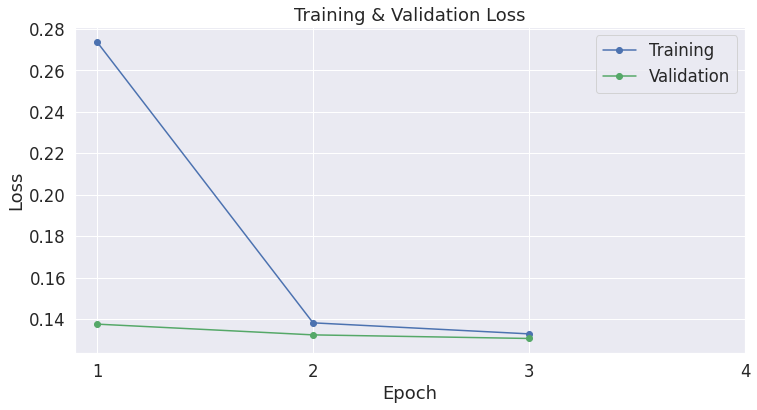

In [27]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [29]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/michael_project/model_save/caio'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/michael_project/model_save/caio


('/content/drive/MyDrive/michael_project/model_save/caio/tokenizer_config.json',
 '/content/drive/MyDrive/michael_project/model_save/caio/special_tokens_map.json',
 '/content/drive/MyDrive/michael_project/model_save/caio/vocab.json',
 '/content/drive/MyDrive/michael_project/model_save/caio/merges.txt',
 '/content/drive/MyDrive/michael_project/model_save/caio/added_tokens.json')

In [30]:
!ls -l --block-size=K ./model_save/

ls: cannot access './model_save/': No such file or directory


In [31]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

ls: cannot access './model_save/pytorch_model.bin': No such file or directory


In [32]:
# Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

# Generate Text

In [33]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: We should be using the phone for surveillance.


1: Dwight? [to Andy]


2: Oh, I'm sorry, but that's not what I said... Okay, uh, it's not my fault, that's what you said.


3: Ow, who did you think you were in the right, I want to say, with...


4: [mock sighs] I hate them.


5: Yes, sir. Aaaaah. That's a very nice compliment.


6: [phone rings] Hey, Pam.  Is somebody else here?  Yeah, we've got a problem.  Is somebody else?


7: No, no. No, no.  You, it wasn't my fault.  It was me.  I knew exactly who did it.  I knew where he was from.  He was on TV, so who knows?  Who does it. [walks out onto the kitchen porch] Yeah, I understand what you're saying.  You didn't stop the traffic.


8: No. I am not going to take that. [points to a note on Michael's desk and holds it in his lap and walks away. There is a flash of fire from that point]


9: Yes.  I do not.  This is a joke, Dwight.  It is an  accident of childhood.  I was trying to make fun of Dwight,

These aren't bad at all!
